In [85]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from munch import Munch
from scipy.linalg import eigvalsh, qr
from numpy import linalg as lg

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 4.0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [313]:
from scipy.linalg import qr
A = np.random.random((2,2))

w, v = np.linalg.eig(A)
i = np.argsort(w)
Q2 = v[:, i]

Q, R, P = qr(A, pivoting = True)
Q, Q2, np.dot(Q2[:, 0], Q2[:,1])

(array([[-0.9121197 , -0.40992397],
        [-0.40992397,  0.9121197 ]]),
 array([[-0.58606673,  0.93359717],
        [ 0.81026279,  0.35832432]]),
 -0.2568133754026403)

In [314]:
from numpy.linalg import eigvals, qr
from scipy.linalg import qr
from scipy.stats import sem
def mean_and_error(x, axis = -1): return np.mean(x, axis = axis), sem(x, axis = axis)
        

def localisation_length(T, E, threshold = 1e8, limit = 10, L = 200):
    """
    Takes a function T that generates NxN matrices and calculates the localisation length.
    """
    N = T(E).shape[0]
    Q = np.identity(N)
    c = np.zeros(N, dtype =  np.complex128)
    l = 0
    while l <= L:
        for count in range(limit):
#             if np.max(np.abs(Q)) > threshold: break
            Q = T(E) @ Q
            l += 1
            
        c += np.log((1+0.0j) * eigvals(Q))
        Q = qr(Q, pivoting = True)[0]
        
    return max(L / c)

def T(E, h = 1, t = 1):
    sign = np.random.choice([-1,1])
    return np.array([
        [-1/t*(E + sign*h),       -1],
        [1,             0]])

def localisation_length_mac(h, E, limit = 10, L = 200):
    """
    Takes a function T that generates NxN matrices and calculates the localisation length.
    """
    A, B = np.zeros(shape = (2, L))
    A[0] = 0
    A[1] = 1
    B[0] = 1
    c = 0
    
    for i in range(1, L-1):
        
        
        if i%limit == 0:
            A[i-1] = A[i-1]/A[i]
            A[i] = 1
            
        c -= np.log((1+0.0j)*A[i])
        
        A[i+1] = (E - h[i])*A[i] - A[i-1]
        
    return - L / c

L = 100
replications = 50
Es = np.linspace(-5,5,100)

Ls, dLs = mean_and_error(np.array([[localisation_length(T, E = E, L = L)
                                     for _ in range(replications)] for E in Es]), axis = -1)

mac_Ls, mac_dLs = mean_and_error(np.array([[localisation_length_mac(E = E, L = L, h = np.random.choice([-1,1], size = L))
                                     for _ in range(replications)] for E in Es]), axis = -1)

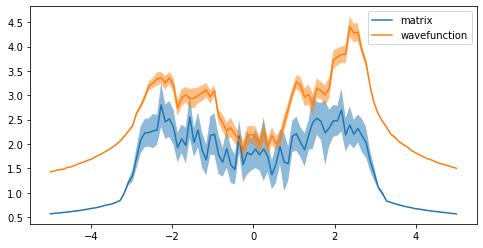

In [315]:
f, ax = plt.subplots()

ax.plot(Es, np.real(Ls), label = "matrix")
ax.fill_between(Es, np.real(Ls-dLs), np.real(Ls+dLs), alpha = 0.5)

ax.plot(Es, 10*np.real(mac_Ls), label = "wavefunction")
ax.fill_between(Es, 10*np.real(mac_Ls-mac_dLs), 10*np.real(mac_Ls+mac_dLs), alpha = 0.5)

ax.legend()

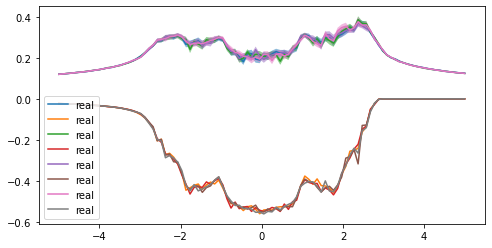

In [241]:
L = 100
replications = 50
Es = np.linspace(-5,5,100)

f, ax = plt.subplots()
for n in [100, 200, 400, 800]:
    Ls, dLs = mean_and_error(np.array([[localisation_length_mac(E = E, L = L, h = np.random.choice([-1,1], size = L))
                                    for i in range(replications)] for E in Es]), axis = -1)
  
    ax.plot(Es, np.real(Ls), label = "real")
    ax.fill_between(Es, np.real(Ls-dLs), np.real(Ls+dLs), alpha = 0.5)
    ax.plot(Es, np.imag(Ls), linestyle = '-', label = "real")
    ax.fill_between(Es, np.imag(Ls-dLs), np.imag(Ls+dLs), alpha = 0.5)

# ax.set(ylim = ())
ax.legend()

In [248]:
def mean_and_error(x, axis = -1): return np.nanmean(x, axis = axis), sem(x, axis = axis)

def localisation_length_array(Ts, Es, threshold = 1e10, limit = 200, L = 500):
    """
    Takes a function T(Es) that generates len(Es) NxN matrices and calculates the localisation length.
    """
    N = Ts(Es).shape[-1]
    Q = np.ones_like(Es)[:, None, None] * np.identity(N)[None, :, :]
    c = np.ones_like(Es)[:, None] * np.zeros(N, dtype =  np.complex128)
    l = 0
    while l < L:
        for count in range(limit):
            #Q = T(Es) @ Q
            if np.max(np.abs(Q))/np.min(np.abs(Q)) > threshold: break
            Q = np.einsum("iab, ibc -> iac", Ts(Es), Q, out = Q)
            l += 1
            
        c += np.log((1+0.0j)*eigvals(Q))
        Q = np.array([qr(q)[0] for q in Q])
    return np.max(l / c, axis = -1)

def Ts(Es, h = 1, t = 1):
    sign = np.random.choice([-1,1])
    T = np.array([
        [np.NaN,       -1],
        [1,             0]])
    
    T = np.ones_like(Es)[:, None, None] * T[None, :, :]
    T[:, 0,0] = -1/t*(Es + sign*h)
    return T

       
replications = 25
Es = np.linspace(-5,5,100)
Ls, dLs = mean_and_error(np.array([localisation_length_array(Ts, Es) for i in range(replications)]), axis = 0)

/Users/tom/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


KeyboardInterrupt: 

In [ ]:
replications = 50
Es = np.linspace(-5,5,100)

f, ax = plt.subplots()
for n in [100, 200, 400, 800]:
    Ls, dLs = mean_and_error(np.array([localisation_length_array(Ts, Es, L = n) for i in range(replications)]), axis = 0)
  
    ax.plot(Es, np.real(Ls), label = "real")
    ax.fill_between(Es, np.real(Ls-dLs), np.real(Ls+dLs), alpha = 0.5)
    ax.plot(Es, np.imag(Ls), linestyle = '-', label = "real")
    ax.fill_between(Es, np.imag(Ls-dLs), np.imag(Ls+dLs), alpha = 0.5)

ax.set(ylim = ())
ax.legend()

What do the matrices actually look like?

In [13]:
from sympy import *
init_printing(use_unicode=True)
from sympy.abc import E, h, 

In [43]:
Tp = Matrix([[-(h+E), -1],[1, 0]])
Tm = Matrix([[-(-h+E), -1],[1, 0]])
def c(a,b): return a*b - b*a
Tp, Tm, c(Tp, Tm), c(c(Tp, Tm), Tp), c(c(Tp, Tm), Tm)

⎛⎡-E - h  -1⎤  ⎡-E + h  -1⎤  ⎡ 0   2⋅h⎤  ⎡    4⋅h       -2⋅h⋅(-E - h)⎤  ⎡    4
⎜⎢          ⎥, ⎢          ⎥, ⎢        ⎥, ⎢                           ⎥, ⎢     
⎝⎣  1     0 ⎦  ⎣  1     0 ⎦  ⎣2⋅h   0 ⎦  ⎣2⋅h⋅(-E - h)      -4⋅h     ⎦  ⎣2⋅h⋅(

⋅h       -2⋅h⋅(-E + h)⎤⎞
                      ⎥⎟
-E + h)      -4⋅h     ⎦⎠

In [21]:
Tm.eigenvects()

⎡⎛                                            ⎡⎡             _________________
⎢⎜            ___________________________     ⎢⎢            ╱  2            2 
⎢⎜  E   h   ╲╱ (-E + h - 2)⋅(-E + h + 2)      ⎢⎢  E   h   ╲╱  E  - 2⋅E⋅h + h  
⎢⎜- ─ + ─ - ─────────────────────────────, 1, ⎢⎢- ─ + ─ - ────────────────────
⎢⎜  2   2                 2                   ⎢⎢  2   2              2        
⎢⎜                                            ⎢⎢                              
⎣⎝                                            ⎣⎣                1             

____⎤⎤⎞  ⎛                                            ⎡⎡             _________
    ⎥⎥⎟  ⎜            ___________________________     ⎢⎢            ╱  2      
- 4 ⎥⎥⎟  ⎜  E   h   ╲╱ (-E + h - 2)⋅(-E + h + 2)      ⎢⎢  E   h   ╲╱  E  - 2⋅E
────⎥⎥⎟, ⎜- ─ + ─ + ─────────────────────────────, 1, ⎢⎢- ─ + ─ + ────────────
    ⎥⎥⎟  ⎜  2   2                 2                   ⎢⎢  2   2              2
    ⎥⎥⎟  ⎜                                         

In [44]:
def sucessor(tp, tm):
    return tp*tm, tm*tp

def iterate(tp, tm, number):
    for i in range(number): tp, tm = sucessor(tp, tm)
    return tp, tm
        
Tp = Matrix([[-(h+E), -1],[1, 0]])
Tm = Matrix([[-(-h+E), -1],[1, 0]])
Tp, Tm = iterate(Tp, Tm, 5)
collect(Tp[0,0].expand(), E)

In [64]:
def sucessor(tp, tm):
    return tp@tm, tm@tp

def iterate(tp, tm, number):
    for i in range(number): tp, tm = sucessor(tp, tm)
    return tp, tm
        
Es = np.linspace(-5,5,100)
L = 0
Tp = np.array([[-(1+Es), -1],[1, 0]])
Tm = np.array([[-(-1+Es), -1],[1, 0]])
print(Tp.shape)

Tp, Tm = iterate(Tp, Tm, L)
eigvalsh(Tp), np.log(eigvalsh(Tp))

(2, 2)


/Users/tom/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.
/Users/tom/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


ValueError: object arrays are not supported

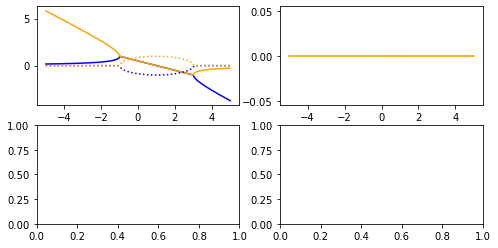

In [122]:
h = 1
Es = np.linspace(-5,5,100)
T = np.empty(shape = (len(Es), 2, 2))
T[:, 0, 0] = -Es
T[:, 0, 1] = -1
T[:, 1, 0] = 1
T[:, 1, 1] = 0

Tp = T.copy()
Tp[:, 0, 0] += h

Tm = T.copy()
Tm[:, 0, 0] -= h

es = lg.eigvals(Tp)
l = np.min(es, axis = -1)
h = np.max(es, axis = -1)

def cplot(self, x, y, *args, **kwargs):
    self.plot(x, np.real(y), *args, **kwargs)
    self.plot(x, np.imag(y), *args, **kwargs, linestyle = "dotted")

f, axes = plt.subplots(nrows = 2, ncols = 2)
for a in axes.flatten(): a.cplot = cplot

axes[0,0].plot(Es, np.real(l), color = 'blue')
axes[0,0].plot(Es, np.real(h), color = 'orange')

axes[0,0].plot(Es, np.imag(l), color = 'blue', linestyle = "dotted")
axes[0,0].plot(Es, np.imag(h), color = 'orange', linestyle = "dotted")

lam = L / np.log(l)
axes[0,1].plot(Es, np.real(lam), color = 'orange')
axes[0,1].plot(Es, np.real(lam), color = 'orange', linestyle = "dotted")


    at order 0
    min eigenval of Tp is  (-5.82842712474619+0j)
    min eigenval of Tm is (-3.732050807568877+0j)
    max eigenval of Tp is  (3.732050807568877+0j)
    max eigenval of Tm is (5.82842712474619+0j)
    

    at order 1
    min eigenval of Tp is  (-2.6150469239352456+0j)
    min eigenval of Tm is (-2.6150469239352456+0j)
    max eigenval of Tp is  (21.954451150103324+0j)
    max eigenval of Tm is (21.954451150103324+0j)
    

    at order 2
    min eigenval of Tp is  (-5.812408902417974+0j)
    min eigenval of Tm is (-5.812408902417974+0j)
    max eigenval of Tp is  (477.9979079406345+0j)
    max eigenval of Tm is (477.9979079406345+0j)
    


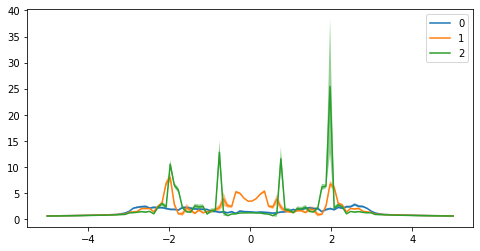

In [340]:
def sucessor(tp, tm):
    return np.einsum("...ab,...bc->...ac", tp, tm),  np.einsum("...ab,...bc->...ac", tm, tp)

def iterate(tp, tm, number):
    for i in range(number): tp, tm = sucessor(tp, tm)
    return tp, tm

def localisation_length(T, E, threshold = 1e8, limit = 10, L = 200, order = 1, h = 1):
    """
    Takes a function T that generates NxN matrices and calculates the localisation length.
    """
    Tp = np.array([[-(E+h), -1],[1, 0]])
    Tm = np.array([[-(E-h), -1],[1, 0]])
    Tp, Tm = iterate(Tp, Tm, order)
    
    
    N = T(E).shape[0]
    Q = np.identity(N)
    c = np.zeros(N, dtype =  np.complex128)
    l = 0
    while l <= L//(2**order):
        for count in range(limit//2**order):
            Q = (Tp if np.random.choice([0, 1]) else Tm) @ Q
            l += 1
            if np.max(np.abs(Q)) > threshold: break
            
        c += np.log((1+0.0j) * eigvals(Q))
        Q = qr(Q, pivoting = True)[0]
        
    return max(L / c)
        
L = 2**8
replications = 100
Es = np.linspace(-5,5,100)
f, ax = plt.subplots()

for order in range(3):
    Tp = np.array([[-(0+1), -1],[1, 0]])[None, :, :] * np.ones_like(Es)[:, None, None]
    Tm = np.array([[-(0-1), -1],[1, 0]])[None, :, :] * np.ones_like(Es)[:, None, None]
    Tp[:, 0,0] = -(Es+1)
    Tm[:, 0,0] = -(Es-1)
    
    Tp, Tm = iterate(Tp, Tm, order)
    print(f"""
    at order {order}
    min eigenval of Tp is  {np.min(np.linalg.eigvals(Tp))}
    min eigenval of Tm is {np.min(np.linalg.eigvals(Tm))}
    max eigenval of Tp is  {np.max(np.linalg.eigvals(Tp))}
    max eigenval of Tm is {np.max(np.linalg.eigvals(Tm))}
    """)
    
    Ls, dLs = mean_and_error(np.array([[localisation_length(T, E = E, L = L, order = order)
                                     for _ in range(replications)] for E in Es]), axis = -1)



    ax.plot(Es, np.real(Ls), label = f"{order}")
    ax.fill_between(Es, np.real(Ls-dLs), np.real(Ls+dLs), alpha = 0.5)

ax.legend()


    at order 0
    min eigenval of Tp is  (-5.82842712474619+0j)
    min eigenval of Tm is (-3.732050807568877+0j)
    max eigenval of Tp is  (3.732050807568877+0j)
    max eigenval of Tm is (5.82842712474619+0j)
    

    at order 1
    min eigenval of Tp is  (-2.6150469239352456+0j)
    min eigenval of Tm is (-2.6150469239352456+0j)
    max eigenval of Tp is  (21.954451150103324+0j)
    max eigenval of Tm is (21.954451150103324+0j)
    

    at order 2
    min eigenval of Tp is  (-5.812408902417974+0j)
    min eigenval of Tm is (-5.812408902417974+0j)
    max eigenval of Tp is  (477.9979079406345+0j)
    max eigenval of Tm is (477.9979079406345+0j)
    

    at order 3
    min eigenval of Tp is  (-13.823348261417456+0j)
    min eigenval of Tm is (-13.823348261417456+0j)
    max eigenval of Tp is  (230385.99999565945+0j)
    max eigenval of Tm is (230385.99999565945+0j)
    

    at order 4
    min eigenval of Tp is  (-196.23298315059384+0j)
    min eigenval of Tm is (-196.2329831505

/Users/tom/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/tom/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/tom/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/tom/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/tom/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/Users/tom/miniconda3/lib/python3.7/site-packages/ipykernel_launch

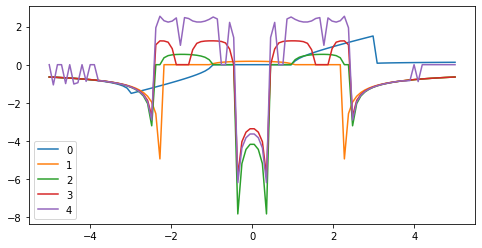

In [353]:
Es = np.linspace(-5,5,100)
f, ax = plt.subplots()

for order in range(5):
    Tp = np.array([[-(0+1), -1],[1, 0]])[None, :, :] * np.ones_like(Es)[:, None, None]
    Tm = np.array([[-(0-1), -1],[1, 0]])[None, :, :] * np.ones_like(Es)[:, None, None]
    Tp[:, 0,0] = -(Es+1)
    Tm[:, 0,0] = -(Es-1)
    
    Tp, Tm = iterate(Tp, Tm, order)
    print(f"""
    at order {order}
    min eigenval of Tp is  {np.min(np.linalg.eigvals(Tp))}
    min eigenval of Tm is {np.min(np.linalg.eigvals(Tm))}
    max eigenval of Tp is  {np.max(np.linalg.eigvals(Tp))}
    max eigenval of Tm is {np.max(np.linalg.eigvals(Tm))}
    """)
    
    Tpe = np.min(np.linalg.eigvals(Tp), axis = -1)
    Tme = np.min(np.linalg.eigvals(Tm), axis = -1)
    lamp = 2**order / np.log(Tpe)
    lamm = 2**order / np.log(Tme)
    lam = 2*2**order / (np.log((1+0.0j)*Tpe) + np.log((1+0.0j)*Tme))

#     ax.plot(Es, lamp, label = f"p", linestyle = '-')
#     ax.plot(Es, lamm, label = f"m", linestyle = ':')
    ax.plot(Es, lam, label = f"{order}")

ax.legend()